<a href="https://colab.research.google.com/github/CUAI-Deeplearning/Pytorch-NLP-Study/blob/beomjin/BERT_sentence_order.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT 
## - Sentence Order Finding

질문 : BERT로 수능 영어 지문 순서를 맞출 수 있는가?

대답 : Yes!

Bert input으로  **text_A , text_B, label** 3 가지를 넣을 수 있다.

따라서 지문들에 대한 경우의 수를 생각해, 가장 확률이 높은 경우를 선택하면 됩니다. 

 <br/> 
  ex) A, B, C 세 개의 지문이 있을 때,

 start - A - B - C  == sum(\[start-A, A-B, B-C])

 start - A - C - B  == sum(\[start-A, A-C, B-C])

## BERT로 구해야 하는 경우는 총 9 가지
임의의 S에 대하여
* start -> S  = 3 가지
* S1 -> S2   = 3*2 가지 


<br/>
<img src="https://gluon-nlp.mxnet.io/_images/bert-sentence-pair.png"
     style="float: left; margin-right: 10px;" width=500; height=400; />




In [0]:
# 예시
ANSWER  = [3,2,1]

start = "Movies may be said to support the dominant culture and to serve as a means for its reproduction over time."

sent1 = "The bad guys are usually punished; the romantic couple almost always find each other despite the obstacles and difficulties they encounter on the path to true love; and the way we wish the world to be is how, in the movies, it more often than not winds up being. No doubt it is this utopian aspect of movies that accounts for why we enjoy them so much."
sent2 = "The simple answer to this question is that movies do more than present two-hour civics lessons or editorials on responsible behavior. They also tell stories that, in the end, we find satisfying."
sent3 = "But one may ask why audiences would find such movies enjoyable if all they do is give cultural directives and prescriptions for proper living. Most of us would likely grow tired of such didactic movies and would probably come to see them as propaganda, similar to the cultural artwork that was common in the Soviet Union and other autocratic societies."

Bert에 의해서 모든 경우의 수에 대하여 3, 2 ,1 로 문장을 선택했을 때, 확률이 최대가 나오게 한다.

# Code

1. Bert 를 import 한다
2. Stanford lmdb 영화 감성 분석 Sentence를 활용해서 자연스러운 문장을 고른다
3. 진짜 순차적인 문장은 1(Real), 문장 순서를 임의로 섞어 가짜 문장을 만들어 0(Fake)로 레이블 한다.
4. 훈련을 진행하고 Prediction을 한다. 

* Test도 만들고 싶지만 패스

In [13]:
# 1. BERT 깔기
!pip install bert-tensorflow

     |████████████████████████████████| 71kB 2.4MB/s 


In [0]:
# 2. 라이브러리 임포트 

from sklearn.model_selection import train_test_split 
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime

import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

In [0]:
# 3. lmdb 데이터를 불러오기 위한 함수들

from tensorflow import keras
import os
import re

# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)
  
  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))
  
  return train_df, test_df

In [16]:
# 4. Train, Test 받기 
train, test = download_and_load_datasets()

84131840/84125825 [==============================] - 4s 0us/step


In [0]:
# 5. sampling 을 통해서 진행 (기존 데이터를 섞기 위함인데 우리는 새로운 데이터를 만들기 때문에 필요없다. 다시 sampling 해야 함.)

data = train.sample(10000)

Sentence 를 두 개로 분해하기

* sentenceA --> 0        <=  len(sentenceA)  < half len

* sentenceB --> half len <   len(sentenceB)  < len  


In [0]:
# 6. BERT 에 COLUMN 명을 알려주기 위한 정의

FIRST_COLUMN = 'sentenceA'
SECOND_COLUMN = 'sentenceB'
LABEL_COLUMN = 'pair'

In [0]:
# 7. 기존 BERT처리에는 없는 새로운 데이터를 만들기 위한 코드
# Fake는 아직 구현 안됨.
data[FIRST_COLUMN] = data['sentence'].apply(lambda x : x[: x.find('. ', 0)])
data[SECOND_COLUMN] = data['sentence'].apply(lambda x : x[ x.find('. ', 0)+1 : x.find('. ', x.find('. ')+1)] )
data[LABEL_COLUMN] = 1
data.drop(['sentence','sentiment', 'polarity'], axis=1, inplace=True)

In [20]:
data.head()

,sentenceA,sentenceB,pair
8083,Despite being a sequel to the more potent orig...,There are some pretty darn funny sex scenes w...,1
15903,"The clichéd Polynesian males drink, fight and ...",Real life Polynesians are much funnier than t...,1
5616,Although in some aspects Seven Pounds is solid...,The movie becomes more and more sappy and man...,1
11903,What ever possessed Martin Scorcese to remake ...,Scorcese especially)- attitudes that compel w...,1
1125,Despite an overall pleasing plot and expensive...,Where were the Japanese wardrobe and cultural...,1


Text(0.5, 1.0, 'Sentence A vs Sentence B')

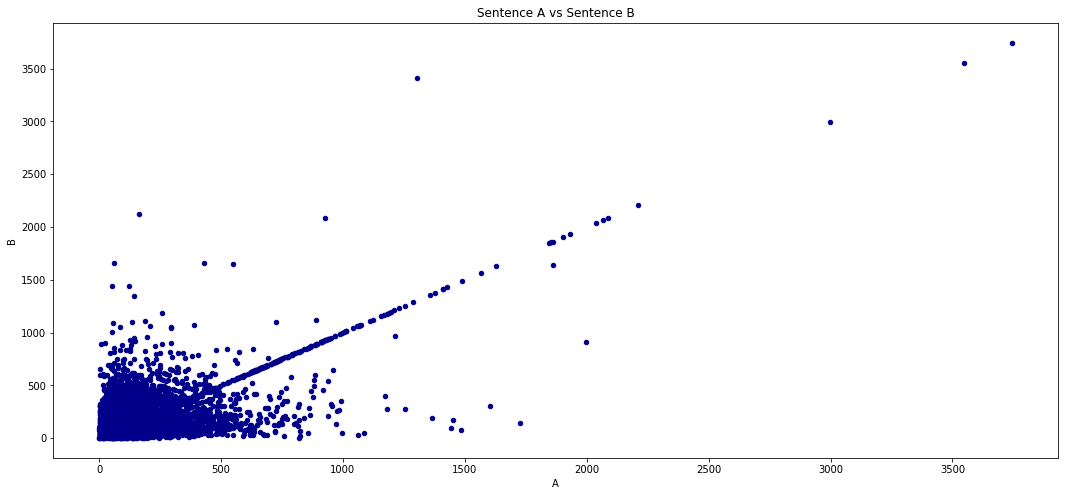

In [21]:
# 8. 단어 수를 보기 위한 Plot
import matplotlib.pyplot as plt

f, ax = plt.subplots(1,1, figsize=(18,8))

A = data.sentenceA.apply(lambda x : len(x.split()))
B = data.sentenceB.apply(lambda x : len(x.split()))

pd.DataFrame({'A':A, 'B':B}).plot.scatter(x='A', y='B', c='DarkBlue', ax=ax)

ax.set_title('Sentence A vs Sentence B')

In [0]:
# 9. Data로 부터 BERT용 input 만들기
# Use the InputExample class from BERT's run_classifier code to create examples from the data
data_InputExamples = data.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[FIRST_COLUMN], 
                                                                   text_b = x[SECOND_COLUMN], 
                                                                   label = x[LABEL_COLUMN]), axis = 1)
label_list = [0,1]

In [35]:
# 10. BERT Hub와 Tokenizer 정의
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [36]:
# 11. 토크나이저 실험
tokenizer.tokenize("This here's an example of using the BERT tokenizer")

['this',
 'here',
 "'",
 's',
 'an',
 'example',
 'of',
 'using',
 'the',
 'bert',
 'token',
 '##izer']

In [37]:
# 12. 하이퍼 파라미터 세팅

# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(data_InputExamples, label_list,MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 10000


INFO:tensorflow:Writing example 0 of 10000


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] despite being a sequel to the more potent original , this is more of a comical remake of friday the 13th concerning the further antics of psycho ##pathic angela , killing more nu ##bil ##e teens for their " im ##moral ##ity " at a camp . < br / > < br / > pamela springsteen ( sister of bruce ) looks [SEP] there are some pretty dar ##n funny sex scenes with some pretty dar ##n attractive girls , but the movie ' s so ( un ##int ##ent ##ional ##ly ) comedic rather than suspense ##ful , it ' s a stink ##er . < br / > < br / > * out of * * * * . < br / [SEP]


INFO:tensorflow:tokens: [CLS] despite being a sequel to the more potent original , this is more of a comical remake of friday the 13th concerning the further antics of psycho ##pathic angela , killing more nu ##bil ##e teens for their " im ##moral ##ity " at a camp . < br / > < br / > pamela springsteen ( sister of bruce ) looks [SEP] there are some pretty dar ##n funny sex scenes with some pretty dar ##n attractive girls , but the movie ' s so ( un ##int ##ent ##ional ##ly ) comedic rather than suspense ##ful , it ' s a stink ##er . < br / > < br / > * out of * * * * . < br / [SEP]


INFO:tensorflow:input_ids: 101 2750 2108 1037 8297 2000 1996 2062 16834 2434 1010 2023 2003 2062 1997 1037 29257 12661 1997 5958 1996 6122 7175 1996 2582 27440 1997 18224 25940 10413 1010 4288 2062 16371 14454 2063 13496 2005 2037 1000 10047 22049 3012 1000 2012 1037 3409 1012 1026 7987 1013 1028 1026 7987 1013 1028 17217 26002 1006 2905 1997 5503 1007 3504 102 2045 2024 2070 3492 18243 2078 6057 3348 5019 2007 2070 3492 18243 2078 8702 3057 1010 2021 1996 3185 1005 1055 2061 1006 4895 18447 4765 19301 2135 1007 21699 2738 2084 23873 3993 1010 2009 1005 1055 1037 27136 2121 1012 1026 7987 1013 1028 1026 7987 1013 1028 1008 2041 1997 1008 1008 1008 1008 1012 1026 7987 1013 102


INFO:tensorflow:input_ids: 101 2750 2108 1037 8297 2000 1996 2062 16834 2434 1010 2023 2003 2062 1997 1037 29257 12661 1997 5958 1996 6122 7175 1996 2582 27440 1997 18224 25940 10413 1010 4288 2062 16371 14454 2063 13496 2005 2037 1000 10047 22049 3012 1000 2012 1037 3409 1012 1026 7987 1013 1028 1026 7987 1013 1028 17217 26002 1006 2905 1997 5503 1007 3504 102 2045 2024 2070 3492 18243 2078 6057 3348 5019 2007 2070 3492 18243 2078 8702 3057 1010 2021 1996 3185 1005 1055 2061 1006 4895 18447 4765 19301 2135 1007 21699 2738 2084 23873 3993 1010 2009 1005 1055 1037 27136 2121 1012 1026 7987 1013 1028 1026 7987 1013 1028 1008 2041 1997 1008 1008 1008 1008 1012 1026 7987 1013 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] the cl ##iche ##d poly ##nesian males drink , fight and make a stream of sex ##ist , stupid and un ##fu ##nn ##y remarks [SEP] real life poly ##nesian ##s are much fun ##nier than these stereo ##type ##d , cardboard characters [SEP]


INFO:tensorflow:tokens: [CLS] the cl ##iche ##d poly ##nesian males drink , fight and make a stream of sex ##ist , stupid and un ##fu ##nn ##y remarks [SEP] real life poly ##nesian ##s are much fun ##nier than these stereo ##type ##d , cardboard characters [SEP]


INFO:tensorflow:input_ids: 101 1996 18856 17322 2094 26572 20281 3767 4392 1010 2954 1998 2191 1037 5460 1997 3348 2923 1010 5236 1998 4895 11263 10695 2100 12629 102 2613 2166 26572 20281 2015 2024 2172 4569 14862 2084 2122 12991 13874 2094 1010 19747 3494 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1996 18856 17322 2094 26572 20281 3767 4392 1010 2954 1998 2191 1037 5460 1997 3348 2923 1010 5236 1998 4895 11263 10695 2100 12629 102 2613 2166 26572 20281 2015 2024 2172 4569 14862 2084 2122 12991 13874 2094 1010 19747 3494 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] although in some aspects seven pounds is solid and interesting in some of its narrative style , gabriel ##e mu ##cci ##no ' s project is rather med ##io ##cre [SEP] the movie becomes more and more sap ##py and mani ##pu ##lative as it move toward the end : hearts human and emotional , eyes physical and metaphor ##ical [SEP]


INFO:tensorflow:tokens: [CLS] although in some aspects seven pounds is solid and interesting in some of its narrative style , gabriel ##e mu ##cci ##no ' s project is rather med ##io ##cre [SEP] the movie becomes more and more sap ##py and mani ##pu ##lative as it move toward the end : hearts human and emotional , eyes physical and metaphor ##ical [SEP]


INFO:tensorflow:input_ids: 101 2348 1999 2070 5919 2698 7038 2003 5024 1998 5875 1999 2070 1997 2049 7984 2806 1010 6127 2063 14163 14693 3630 1005 1055 2622 2003 2738 19960 3695 16748 102 1996 3185 4150 2062 1998 2062 20066 7685 1998 23624 14289 26255 2004 2009 2693 2646 1996 2203 1024 8072 2529 1998 6832 1010 2159 3558 1998 19240 7476 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2348 1999 2070 5919 2698 7038 2003 5024 1998 5875 1999 2070 1997 2049 7984 2806 1010 6127 2063 14163 14693 3630 1005 1055 2622 2003 2738 19960 3695 16748 102 1996 3185 4150 2062 1998 2062 20066 7685 1998 23624 14289 26255 2004 2009 2693 2646 1996 2203 1024 8072 2529 1998 6832 1010 2159 3558 1998 19240 7476 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] what ever possessed martin sc ##or ##ces ##e to remake this film ? and not only did he remake it , completely ruin it ? the non ##sen ##sic ##al decision to make the character played by robert den ##iro ( in his most over ##don ##e performance , and that ' s saying a lot ) into a religious fan ##atic is ridiculous , and exemplary of attitudes harbor ##ed by hollywood ( and mr [SEP] sc ##or ##ces ##e especially ) - attitudes that com ##pel writers to think that the best way to make a character insane is to tattoo a cr ##uc ##if ##ix on his back [SEP]


INFO:tensorflow:tokens: [CLS] what ever possessed martin sc ##or ##ces ##e to remake this film ? and not only did he remake it , completely ruin it ? the non ##sen ##sic ##al decision to make the character played by robert den ##iro ( in his most over ##don ##e performance , and that ' s saying a lot ) into a religious fan ##atic is ridiculous , and exemplary of attitudes harbor ##ed by hollywood ( and mr [SEP] sc ##or ##ces ##e especially ) - attitudes that com ##pel writers to think that the best way to make a character insane is to tattoo a cr ##uc ##if ##ix on his back [SEP]


INFO:tensorflow:input_ids: 101 2054 2412 8679 3235 8040 2953 9623 2063 2000 12661 2023 2143 1029 1998 2025 2069 2106 2002 12661 2009 1010 3294 10083 2009 1029 1996 2512 5054 19570 2389 3247 2000 2191 1996 2839 2209 2011 2728 7939 9711 1006 1999 2010 2087 2058 5280 2063 2836 1010 1998 2008 1005 1055 3038 1037 2843 1007 2046 1037 3412 5470 12070 2003 9951 1010 1998 27792 1997 13818 6496 2098 2011 5365 1006 1998 2720 102 8040 2953 9623 2063 2926 1007 1011 13818 2008 4012 11880 4898 2000 2228 2008 1996 2190 2126 2000 2191 1037 2839 9577 2003 2000 11660 1037 13675 14194 10128 7646 2006 2010 2067 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2054 2412 8679 3235 8040 2953 9623 2063 2000 12661 2023 2143 1029 1998 2025 2069 2106 2002 12661 2009 1010 3294 10083 2009 1029 1996 2512 5054 19570 2389 3247 2000 2191 1996 2839 2209 2011 2728 7939 9711 1006 1999 2010 2087 2058 5280 2063 2836 1010 1998 2008 1005 1055 3038 1037 2843 1007 2046 1037 3412 5470 12070 2003 9951 1010 1998 27792 1997 13818 6496 2098 2011 5365 1006 1998 2720 102 8040 2953 9623 2063 2926 1007 1011 13818 2008 4012 11880 4898 2000 2228 2008 1996 2190 2126 2000 2191 1037 2839 9577 2003 2000 11660 1037 13675 14194 10128 7646 2006 2010 2067 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] despite an overall pleasing plot and expensive production one wonders how a director can make so many clumsy cultural mistakes [SEP] where were the japanese wardrobe and cultural consultants ? not on the payroll apparently [SEP]


INFO:tensorflow:tokens: [CLS] despite an overall pleasing plot and expensive production one wonders how a director can make so many clumsy cultural mistakes [SEP] where were the japanese wardrobe and cultural consultants ? not on the payroll apparently [SEP]


INFO:tensorflow:input_ids: 101 2750 2019 3452 24820 5436 1998 6450 2537 2028 16278 2129 1037 2472 2064 2191 2061 2116 22902 3451 12051 102 2073 2020 1996 2887 17828 1998 3451 22283 1029 2025 2006 1996 26854 4593 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2750 2019 3452 24820 5436 1998 6450 2537 2028 16278 2129 1037 2472 2064 2191 2061 2116 22902 3451 12051 102 2073 2020 1996 2887 17828 1998 3451 22283 1029 2025 2006 1996 26854 4593 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


# Creating a model

In [0]:
# 13. 기존 BERT 로 모델 생성 

def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  """Creates a classification model."""

  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [0]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        f1_score = tf.contrib.metrics.f1_score(
            label_ids,
            predicted_labels)
        auc = tf.metrics.auc(
            label_ids,
            predicted_labels)
        recall = tf.metrics.recall(
            label_ids,
            predicted_labels)
        precision = tf.metrics.precision(
            label_ids,
            predicted_labels) 
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        return {
            "eval_accuracy": accuracy,
            "f1_score": f1_score,
            "auc": auc,
            "precision": precision,
            "recall": recall,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
        }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [0]:
# 14. 하이퍼 파라미터 세팅

# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

In [0]:
# 15. 하이퍼 파라미터 세팅

# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)


In [0]:
# 16. 모델 저장을 위한 세팅

import os

# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=os.getcwd(),
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [43]:
# 17. 모델 변수 정의

model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': '/content', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7face821d7b8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7face821d7b8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
# 18. 모델 설정 

# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

In [0]:
# 19. 시작!

print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /content/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/model.ckpt.


INFO:tensorflow:loss = 0.77991927, step = 1


INFO:tensorflow:loss = 0.77991927, step = 1


INFO:tensorflow:global_step/sec: 0.0229756


INFO:tensorflow:global_step/sec: 0.0229756


INFO:tensorflow:loss = 0.00019607582, step = 101 (4352.448 sec)


INFO:tensorflow:loss = 0.00019607582, step = 101 (4352.448 sec)


INFO:tensorflow:global_step/sec: 0.023163


INFO:tensorflow:global_step/sec: 0.023163


INFO:tensorflow:loss = 0.00011099613, step = 201 (4317.227 sec)


INFO:tensorflow:loss = 0.00011099613, step = 201 (4317.227 sec)


In [9]:
""" 테스트용
test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)
"""

NameError: ignored

In [0]:
# 20. BERT 모델로 prediction을 받는 함수

def getPrediction(in_sentences):
  labels = ["Wrong", "Right"]
  input_examples = [run_classifier.InputExample(guid="", text_a = x[0], text_b = x[1], label = 0) for x in in_sentences] # here, "" is just a dummy label
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(sentence, prediction['probabilities'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)] 

  # Return 형태를 보면 문장, 확률, 레이블 반환

In [0]:
# 예시

ANSWER  = [3,2,1]

start = "Movies may be said to support the dominant culture and to serve as a means for its reproduction over time."

sent1 = "The bad guys are usually punished; the romantic couple almost always find each other despite the obstacles and difficulties they encounter on the path to true love; and the way we wish the world to be is how, in the movies, it more often than not winds up being. No doubt it is this utopian aspect of movies that accounts for why we enjoy them so much."
sent2 = "The simple answer to this question is that movies do more than present two-hour civics lessons or editorials on responsible behavior. They also tell stories that, in the end, we find satisfying."
sent3 = "But one may ask why audiences would find such movies enjoyable if all they do is give cultural directives and prescriptions for proper living. Most of us would likely grow tired of such didactic movies and would probably come to see them as propaganda, similar to the cultural artwork that was common in the Soviet Union and other autocratic societies."

In [0]:
pred_sentences = [
  (start, sent1), # Start -> any sentence 
  (start, sent2),
  (start, sent3),
  (sent1, sent2), # Any -> Any 
  (sent1, sent3),
  (sent2, sent1),
  (sent2, sent3),
  (sent3, snet1),
  (sent3, sent2)
]

In [0]:
predictions = getPrediction(pred_sentences)ㄴ